In [2]:
import os
import sys

sys.path.append(os.path.join("..",".."))
sys.path.append(os.path.join("..","..","..",'Data_prep'))
#sys.path.append(os.path.join(".."))

import numpy as np

#import pickle
#import matplotlib.pyplot as plt
#import torch
#from tqdm import tqdm

#from Utils import *

In [5]:
!ls ../VAE_v2_3

bce_results.npy  checkpoint.pt	 desc.txt	  loss_results.npy
best0.pt	 data_split.pkl  kld_results.npy


In [2]:
#import Utils_imp_VAE
from B_VAE.VAE_v2 import b_encodeco

In [15]:
res_dir=os.path.join("..",'VAE_5')

VISTA RAPIDA DE ENTRENAMIENTO

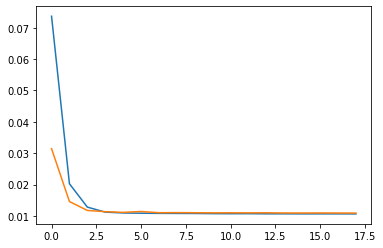

In [16]:
#plt.plot(np.load(os.path.join(res_dir,'bce_results.npy'),allow_pickle=True)['train'])
plt.plot(np.load(os.path.join(res_dir,'bce_results.npy'),allow_pickle=True).tolist()['train'])
plt.plot(np.load(os.path.join(res_dir,'bce_results.npy'),allow_pickle=True).tolist()['valid'])

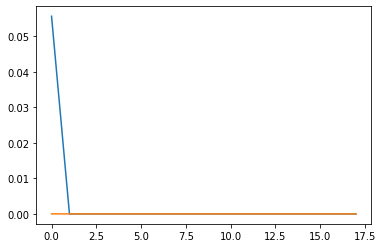

In [17]:
#plt.plot(np.load(os.path.join(res_dir,'bce_results.npy'),allow_pickle=True)['train'])
plt.plot(np.load(os.path.join(res_dir,'kld_results.npy'),allow_pickle=True).tolist()['train'])
plt.plot(np.load(os.path.join(res_dir,'kld_results.npy'),allow_pickle=True).tolist()['valid'])

In [28]:
np.load(os.path.join(res_dir,'loss_results.npy'),allow_pickle=True).tolist()['train']

[0.12926071239568868,
 0.020246934259309155,
 0.01280251413397612,
 0.011199207706914793,
 0.010934101703070893,
 0.010853960314018581,
 0.010806411978112392,
 0.01078518807536292,
 0.010767694491509888,
 0.010717522017059437,
 0.010695043213497473,
 0.010705336306327537,
 0.010660032473539596,
 0.010657636549367312,
 0.010642390357182977,
 0.010649919106626833,
 0.010647141967376116,
 0.010629916910080892]

(0.0106, 0.0111)

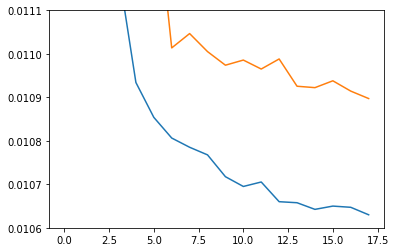

In [25]:
#plt.plot(np.load(os.path.join(res_dir,'bce_results.npy'),allow_pickle=True)['train'])
plt.plot(np.load(os.path.join(res_dir,'loss_results.npy'),allow_pickle=True).tolist()['train'])
plt.plot(np.load(os.path.join(res_dir,'loss_results.npy'),allow_pickle=True).tolist()['valid'])
plt.ylim(0.0106,0.0111)

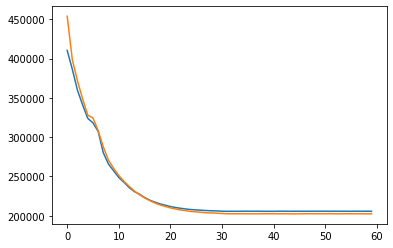

In [4]:
train,test=read_results(np.load(os.path.join(res_dir,'bce_results.npy'),allow_pickle=True),0)
train1,test1=read_results(np.load(os.path.join(res_dir,'bce_results.npy'),allow_pickle=True),1)

plt.plot(test+test1)
plt.plot(train+train1)

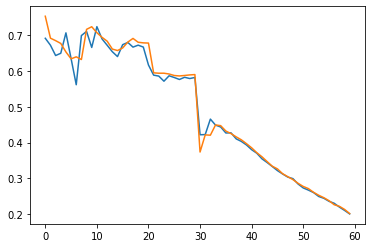

In [5]:
train,test=read_results(np.load(os.path.join(res_dir,'kld_results.npy'),allow_pickle=True),0)
train1,test1=read_results(np.load(os.path.join(res_dir,'kld_results.npy'),allow_pickle=True),1)

plt.plot(test+test1)
plt.plot(train+train1)

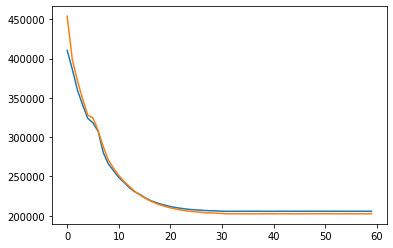

In [6]:
train,test=read_results(np.load(os.path.join(res_dir,'loss_results.npy'),allow_pickle=True),0)
train1,test1=read_results(np.load(os.path.join(res_dir,'loss_results.npy'),allow_pickle=True),1)

plt.plot(test+test1)
plt.plot(train+train1)

CARGA DE RESULTADOS

In [4]:
chpt=torch.load(os.path.join(res_dir,'checkpoint.pt'))
torch.save(chpt['model_state_dict'],"{fname}.pt".format(fname=os.path.join(res_dir,"best"+str(0))))

In [31]:
#a=torch.load('best1.pt')
a=torch.load(os.path.join(res_dir,'best0.pt'))

In [33]:
    model=b_encodeco(image_dim=int(200),
                 image_channels=3,
                 repr_sizes=[10,20,40],
                 layer_sizes=[],
                 latent_space_size=50,
                 conv_kernel_size=15,
                 conv_pooling=False,
                 conv_batch_norm=True,
                 NN_batch_norm=True,
                 stride=2,
                device='cuda')

In [34]:
model.load_state_dict(a)

<All keys matched successfully>

In [35]:
model.eval()

b_encodeco(
  (encoder_conv): b_encoder_conv(
    (im_layers): ModuleList(
      (0): set_conv(
        (comp_layer): ModuleList(
          (0): Conv2d(3, 10, kernel_size=(15, 15), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): set_conv(
        (comp_layer): ModuleList(
          (0): Conv2d(10, 20, kernel_size=(15, 15), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): set_conv(
        (comp_layer): ModuleList(
          (0): Conv2d(20, 40, kernel_size=(15, 15), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
  )
  (encoder_NN_mu): NeuralNet(
    (layers): ModuleList(
      (0): Sequential(
        (0): NN_layer(
          (layer): ModuleList(
            

In [14]:
from torchvision import transforms
from Custom_dataloader import *
from Transforms import phantom_segmentation
from Transforms import phantom_segmentation_
from Transforms import multi_image_resize
from Transforms import multi_ToTensor
from Transforms import output_transform
from Transforms import rgb_normalize

DB="/run/user/1000/gvfs/afp-volume:host=MyCloudPR4100.local,user=aorus_1,volume=Paltas_DataBase/Data_Base_v2"

d_tt=transforms.Compose([
        phantom_segmentation_(False),
        rgb_normalize(ImType=['PhantomRGB']),
        multi_image_resize(ImType=['PhantomRGB'],size=(200,200)),
        multi_ToTensor(ImType=['PhantomRGB']),
        #output_transform()
        ])

datab=Dataset_direct(root_dir=DB,ImType=['PhantomRGB'],Intersec=False,transform=d_tt)

In [23]:
img=datab[500]

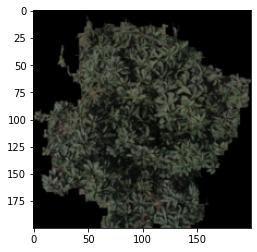

In [24]:
i=img['PhantomRGB']
ir=np.dstack([i[0,:,:],i[1,:,:],i[2,:,:]])
plt.imshow(ir)

In [36]:
print(model.encoder_conv.im_layers)
model.to('cpu')
fl=model.encoder_conv(torch.unsqueeze(img['PhantomRGB'], 0))
fl_=model.flatten(fl)
fl_u=model.encoder_NN_mu(fl_)
fl_sig=model.encoder_NN_sig(fl_)

ModuleList(
  (0): set_conv(
    (comp_layer): ModuleList(
      (0): Conv2d(3, 10, kernel_size=(15, 15), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): set_conv(
    (comp_layer): ModuleList(
      (0): Conv2d(10, 20, kernel_size=(15, 15), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): set_conv(
    (comp_layer): ModuleList(
      (0): Conv2d(20, 40, kernel_size=(15, 15), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)


0


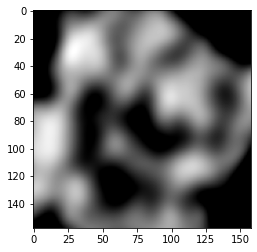

1


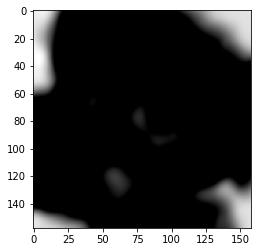

2


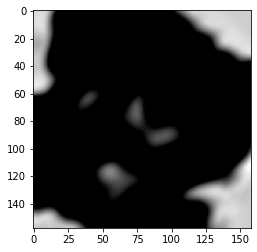

3


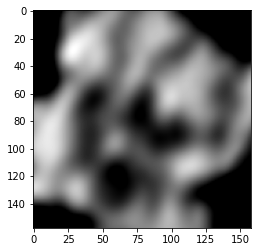

4


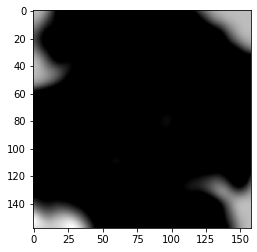

5


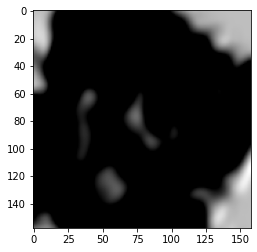

6


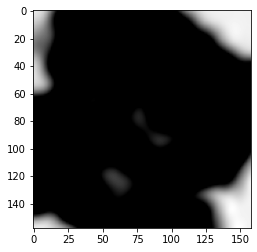

7


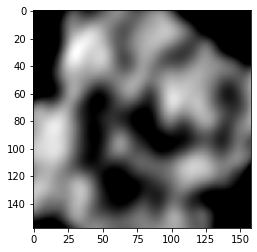

8


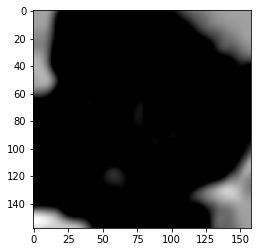

9


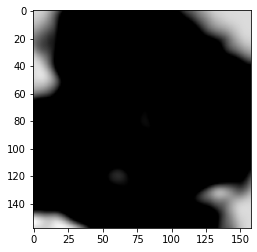

10


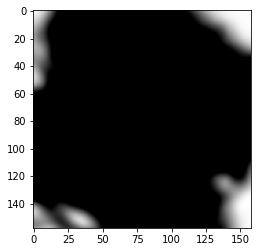

11


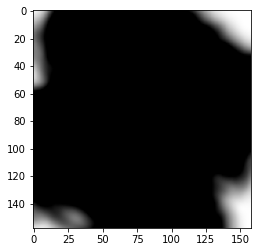

12


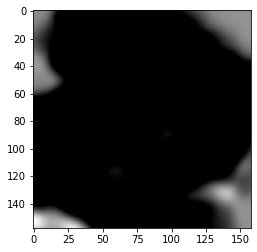

13


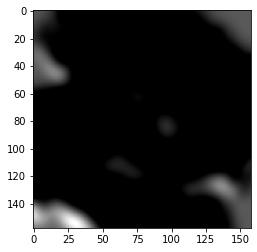

14


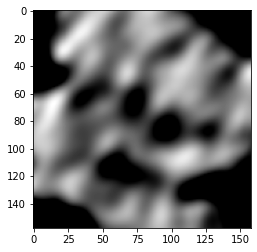

15


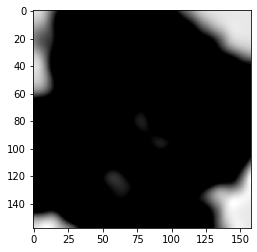

16


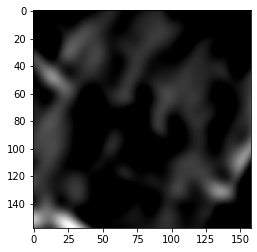

17


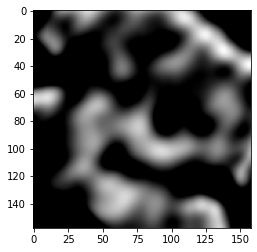

18


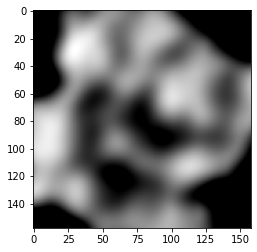

19


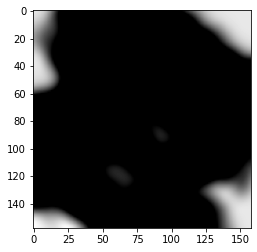

20


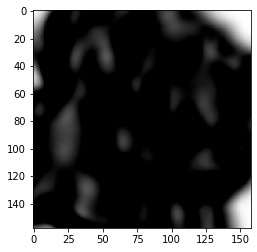

21


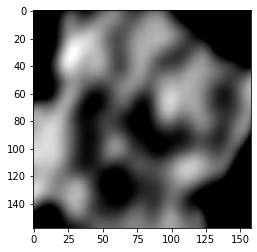

22


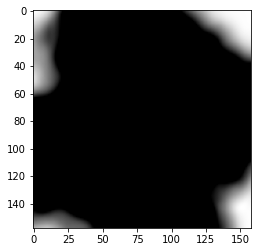

23


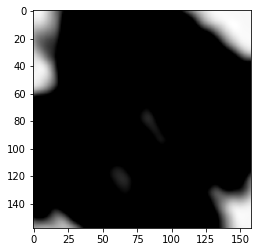

24


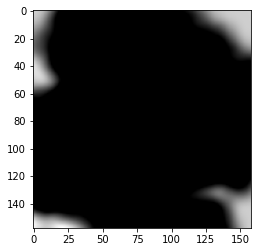

25


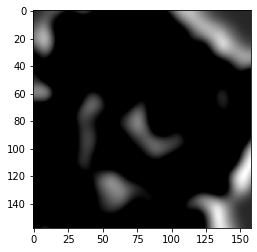

26


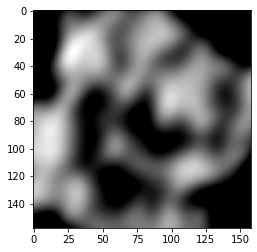

27


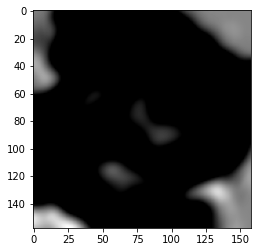

28


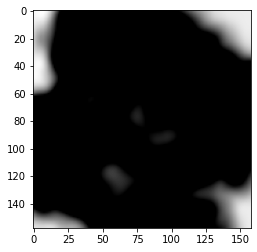

29


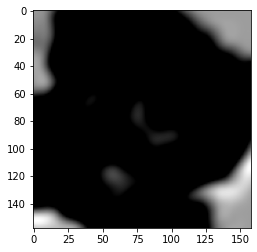

30


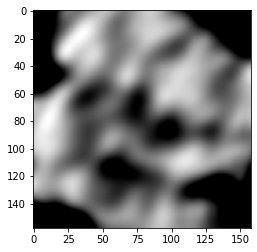

31


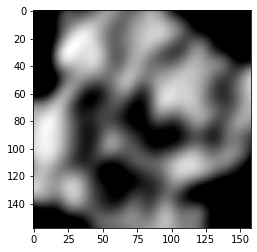

32


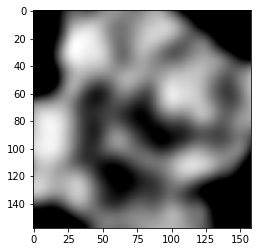

33


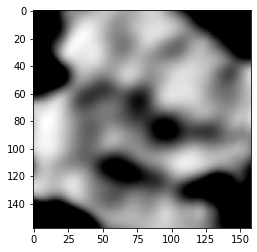

34


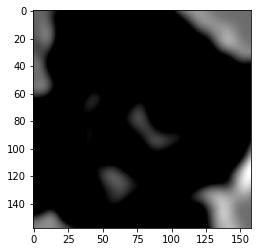

35


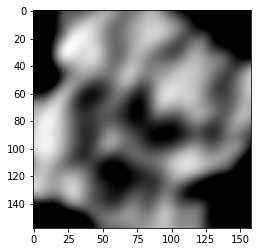

36


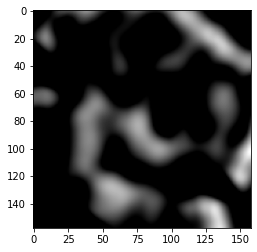

37


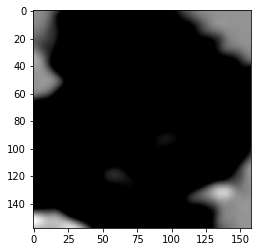

38


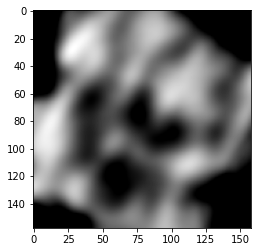

39


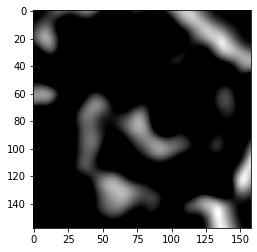

In [37]:
for i in range(40):
    print(i)
    plt.imshow(fl[0,i,:,:].detach().numpy(),cmap='gray')
    plt.show()
#plt.imshow(fl[0,0,:,:].detach().numpy())
#fl[0,0,:,:].detach().numpy().shape

In [38]:
model.to('cuda')
io=model(torch.unsqueeze(img['PhantomRGB'], 0).to('cuda'))

In [39]:
io=io[0].to('cpu').detach().numpy()

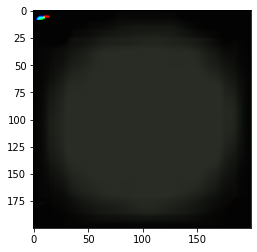

In [40]:
io=io[0,:,:,:]
ir=np.dstack([io[0,:,:],io[1,:,:],io[2,:,:]])
plt.imshow(ir)

In [44]:
np.min(io[0,:,:])

0.013384496

In [36]:
model.to('cpu')
fl=model.encoder_conv(torch.unsqueeze(img['PhantomRGB'], 0))
fl_=model.flatten(fl)
fl_u=model.encoder_NN_mu(fl_)
fl_sig=model.encoder_NN_sig(fl_)

array([[0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       ...,
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854]], dtype=float32)

In [2]:
meta_dir="/run/user/1000/gvfs/afp-volume:host=MyCloudPR4100.local,user=aorus_1,volume=Paltas_DataBase/metadata_VAE_v4"

In [3]:
metad=np.array(os.listdir(meta_dir)[1:])

In [4]:
metad_dict=np.vectorize(lambda meta: pickle.load(open(os.path.join(meta_dir,meta),'rb')))(metad)

In [52]:
meta_u=np.vectorize(lambda dic:dic['u'],signature='()->(j)')(metad_dict)
meta_sig=np.vectorize(lambda dic:dic['sig'],signature='()->(j)')(metad_dict)
meta_C=np.vectorize(lambda dic:dic['Class'][0],otypes=[object],signature='()->()')(metad_dict)
meta_D=np.vectorize(lambda dic:dic['Date'][0],otypes=[object],signature='()->()')(metad_dict)

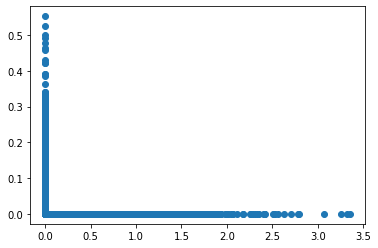

In [9]:
plt.scatter(meta_sig[:,0],meta_sig[:,30])

In [25]:
plt.scatter(meta_u[meta_C=='Control',11],meta_u[meta_C=='Control',-1],color='r',alpha=0.7,s=2)
plt.scatter(meta_u[meta_C=='H50%',11],meta_u[meta_C=='H50%',-1],color='b',alpha=0.3,s=2)

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [13]:
pca = PCA(n_components=2)
pca.fit(meta_u)
meta_u_p=pca.transform(meta_u)

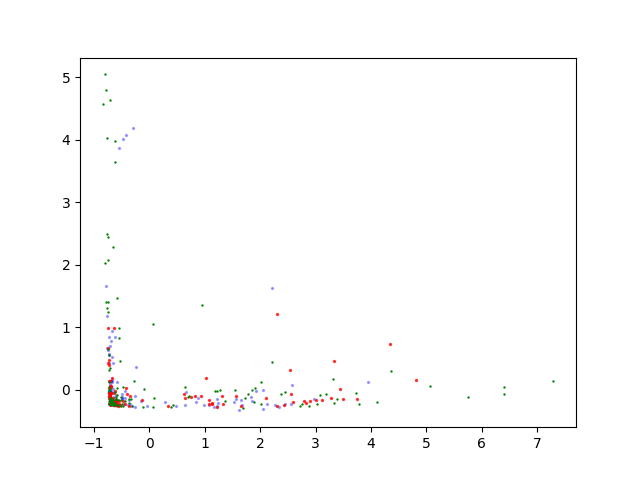

In [26]:
fig = plt.figure()
plt.scatter(meta_u_p[meta_C=='N_Deficiencia',0],meta_u_p[meta_C=='N_Deficiencia',1],color='b',alpha=0.3,s=2)
plt.scatter(meta_u_p[meta_C=='N_Control',0],meta_u_p[meta_C=='N_Control',1],color='r',alpha=0.7,s=2)
plt.scatter(meta_u_p[meta_C=='N_Exceso',0],meta_u_p[meta_C=='N_Exceso',1],color='g',alpha=1.,s=0.5)
#plt.scatter(meta_u_p[meta_C=='H50%',0],meta_u_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)
plt.show()

In [17]:
pca = PCA(n_components=2)
pca.fit(meta_sig)
meta_sig_p=pca.transform(meta_sig)

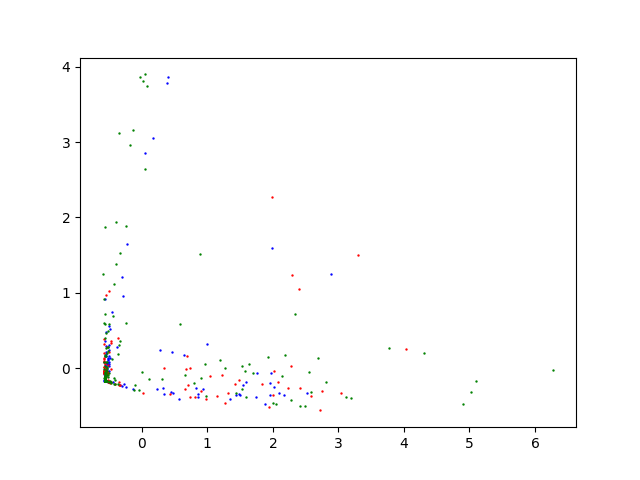

In [28]:
fig = plt.figure()
plt.scatter(meta_sig_p[meta_C=='N_Deficiencia',0],meta_sig_p[meta_C=='N_Deficiencia',1],color='b',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='N_Control',0],meta_sig_p[meta_C=='N_Control',1],color='r',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='N_Exceso',0],meta_sig_p[meta_C=='N_Exceso',1],color='g',alpha=1.,s=0.5)
#plt.scatter(meta_sig_p[meta_C=='H50%',0],meta_sig_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)
plt.show()

In [29]:
pca = TSNE(n_components=2)
meta_sig_p=pca.fit_transform(meta_sig)

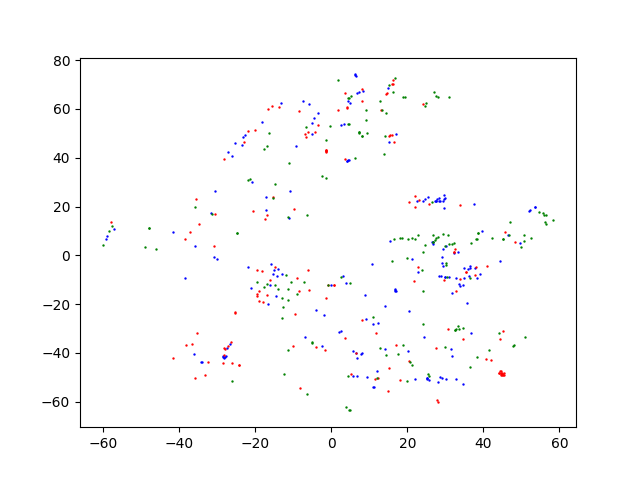

In [35]:
fig = plt.figure()
plt.scatter(meta_sig_p[meta_C=='N_Deficiencia',0],meta_sig_p[meta_C=='N_Deficiencia',1],color='b',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='N_Control',0],meta_sig_p[meta_C=='N_Control',1],color='r',alpha=1.,s=0.5)
plt.scatter(meta_sig_p[meta_C=='N_Exceso',0],meta_sig_p[meta_C=='N_Exceso',1],color='g',alpha=1.,s=0.5)
#plt.scatter(meta_sig_p[meta_C=='H50%',0],meta_sig_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)
plt.show()

In [32]:
pca = TSNE(n_components=2)
meta_u_p=pca.fit_transform(meta_u)

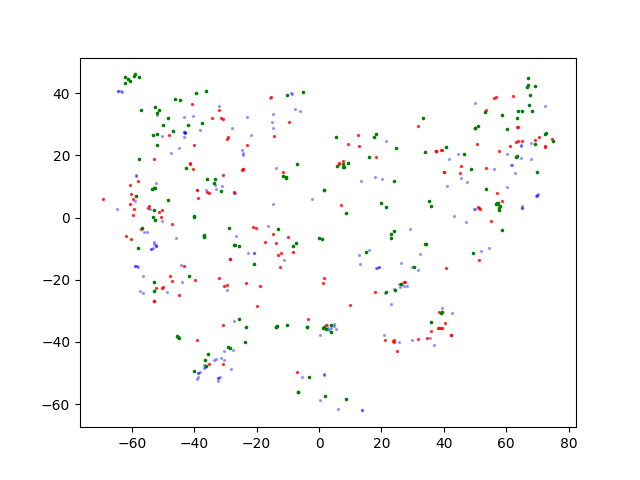

In [37]:
fig = plt.figure()
plt.scatter(meta_u_p[meta_C=='N_Deficiencia',0],meta_u_p[meta_C=='N_Deficiencia',1],color='b',alpha=0.3,s=2)
plt.scatter(meta_u_p[meta_C=='N_Control',0],meta_u_p[meta_C=='N_Control',1],color='r',alpha=0.7,s=2)
plt.scatter(meta_u_p[meta_C=='N_Exceso',0],meta_u_p[meta_C=='N_Exceso',1],color='g',alpha=1.,s=2.5)
#plt.scatter(meta_u_p[meta_C=='H50%',0],meta_u_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)
plt.show()

In [38]:
pca = TSNE(n_components=2)
meta_a_p=pca.fit_transform(np.hstack((meta_u,meta_sig)))

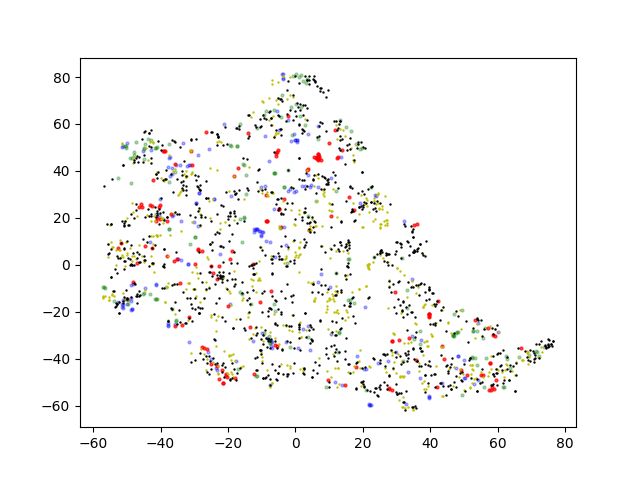

In [39]:
fig = plt.figure()
plt.scatter(meta_a_p[meta_C=='N_Deficiencia',0],meta_a_p[meta_C=='N_Deficiencia',1],color='b',alpha=0.3,s=4.2)
plt.scatter(meta_a_p[meta_C=='N_Control',0],meta_a_p[meta_C=='N_Control',1],color='r',alpha=0.7,s=4.2)
plt.scatter(meta_a_p[meta_C=='N_Exceso',0],meta_a_p[meta_C=='N_Exceso',1],color='g',alpha=.3,s=4.5)
plt.scatter(meta_a_p[meta_C=='H50%',0],meta_a_p[meta_C=='H50%',1],color='y',alpha=1.,s=0.5)
plt.scatter(meta_a_p[meta_C=='Control',0],meta_a_p[meta_C=='Control',1],color='k',alpha=1.,s=0.5)
plt.show()

In [15]:
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [40]:
pca = PCA(n_components=3)
pca.fit(np.hstack((meta_u,meta_sig)))
meta_u_p=pca.transform(np.hstack((meta_u,meta_sig)))

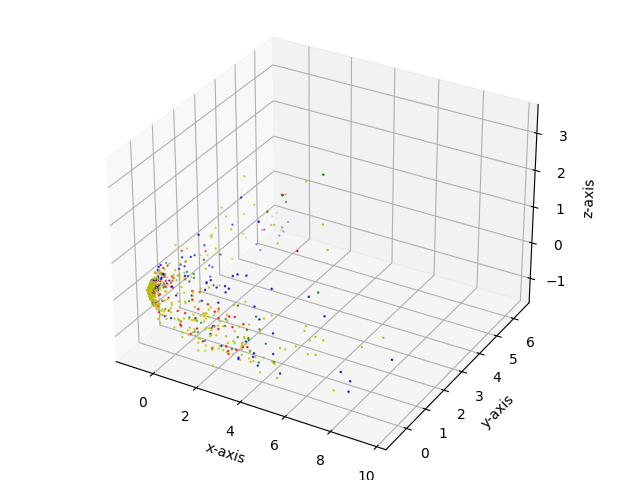

In [41]:
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
ax.scatter(meta_u_p[meta_C=='N_Deficiencia',0],
            meta_u_p[meta_C=='N_Deficiencia',1],
            meta_u_p[meta_C=='N_Deficiencia',2],
           color='red',s=0.5)
ax.scatter(meta_u_p[meta_C=='N_Control',0],
            meta_u_p[meta_C=='N_Control',1],
            meta_u_p[meta_C=='N_Control',2],
           color='green',s=0.5)
ax.scatter(meta_u_p[meta_C=='N_Exceso',0],
            meta_u_p[meta_C=='N_Exceso',1],
            meta_u_p[meta_C=='N_Exceso',2],
           color='blue',s=0.5)
ax.scatter(meta_u_p[meta_C=='H50%',0],
           meta_u_p[meta_C=='H50%',1],
           meta_u_p[meta_C=='H50%',2],
           color='y',s=0.5)
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

In [42]:
pca = TSNE(n_components=3)
meta_u_p=pca.fit_transform(np.hstack((meta_u,meta_sig)))

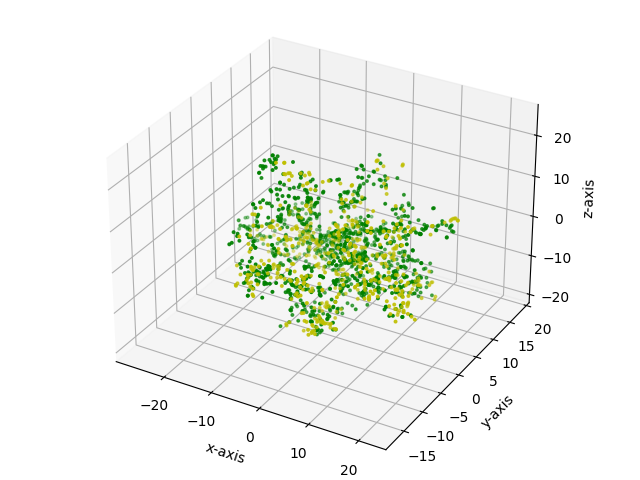

In [46]:
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
#ax.scatter(meta_u_p[meta_C=='N_Deficiencia',0],
#            meta_u_p[meta_C=='N_Deficiencia',1],
#            meta_u_p[meta_C=='N_Deficiencia',2],
#           color='red',s=3.5)
ax.scatter(meta_u_p[meta_C=='Control',0],
            meta_u_p[meta_C=='Control',1],
            meta_u_p[meta_C=='Control',2],
           color='green',s=3.5)
#ax.scatter(meta_u_p[meta_C=='N_Exceso',0],
#            meta_u_p[meta_C=='N_Exceso',1],
#            meta_u_p[meta_C=='N_Exceso',2],
#           color='blue',s=3.5)
ax.scatter(meta_u_p[meta_C=='H50%',0],
           meta_u_p[meta_C=='H50%',1],
           meta_u_p[meta_C=='H50%',2],
           color='y',s=3.5)
  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

In [47]:
pca = TSNE(n_components=3)
meta_u_p=pca.fit_transform(meta_u)

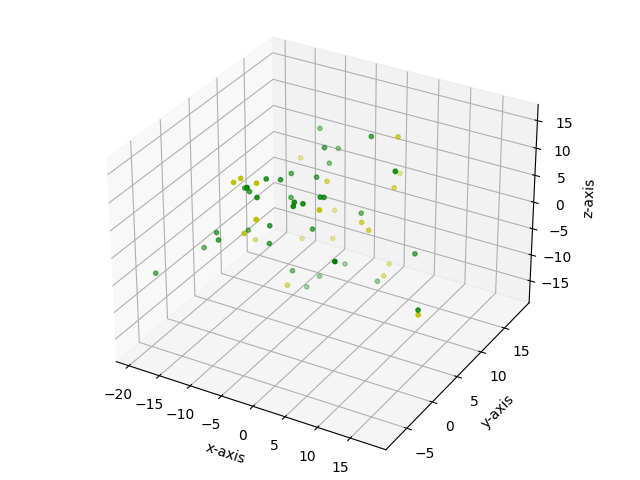

In [86]:
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
#ax.scatter(meta_u_p[meta_C=='N_Deficiencia',0],
#            meta_u_p[meta_C=='N_Deficiencia',1],
#            meta_u_p[meta_C=='N_Deficiencia',2],
#           color='red',s=3.5)
ax.scatter(meta_u_p[np.logical_and(meta_D=='19_agosto_1',meta_C=='Control'),0],
            meta_u_p[np.logical_and(meta_D=='19_agosto_1',meta_C=='Control'),1],
            meta_u_p[np.logical_and(meta_D=='19_agosto_1',meta_C=='Control'),2],
           color='green',s=9.5)
#ax.scatter(meta_u_p[meta_C=='N_Exceso',0],
#            meta_u_p[meta_C=='N_Exceso',1],
#            meta_u_p[meta_C=='N_Exceso',2],
#           color='blue',s=3.5)
ax.scatter(meta_u_p[np.logical_and(meta_D=='19_agosto_1',meta_C=='H50%'),0],
           meta_u_p[np.logical_and(meta_D=='19_agosto_1',meta_C=='H50%'),1],
           meta_u_p[np.logical_and(meta_D=='19_agosto_1',meta_C=='H50%'),2],
           color='y',s=9.5)
  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

In [80]:
np.unique(meta_D)

array(['11_junio_1', '12_mayo_1', '12_mayo_2', '13_agosto_1',
       '14_abril_1', '14_abril_2', '14_julio_1', '15_setiembre_1',
       '16_junio_1', '16_junio_2', '19_agosto_1', '19_mayo_1',
       '19_mayo_2', '23_julio_1', '23_julio_2', '23_junio_1',
       '23_junio_2', '24_setiembre_1', '26_mayo_1', '26_mayo_2',
       '28_abril_1', '28_abril_2', '29_marzo_1', '29_marzo_2',
       '2_julio_1', '2_junio_1', '5_agosto_1', '7_mayo_1', '9_julio_1'],
      dtype=object)